# Feature Engeneering 

In [1]:
## > LIBRARIES
import os
import re
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/prog/functions/')

from ncaa19 import *

sns.set()

## > DATA
path_datasets_old = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/datasets/'
path_datasets = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/datasets/2019/'
path_elab = 'C:/Users/cg08900/Documents/Pandora/Personale/kaggle/NCAA_2k19/elaborazioni/'

df_rs_c_res = pd.read_csv(path_datasets + 'RegularSeasonCompactResults.csv')
df_rs_d_res = pd.read_csv(path_datasets + 'RegularSeasonDetailedResults.csv')
df_teams = pd.read_csv(path_datasets + 'Teams.csv')
df_seeds = pd.read_csv(path_datasets + 'NCAATourneySeeds.csv')
coaches = pd.read_csv(path_datasets + 'TeamCoaches.csv')
df_tourn = pd.read_csv(path_datasets + 'NCAATourneyCompactResults.csv')
mysub = pd.read_csv(path_datasets + 'SampleSubmissionStage2.csv')
massey = pd.read_csv(path_datasets + 'MasseyOrdinals/MasseyOrdinals_2019_only_day_133_52systems.csv')
massey_old = pd.read_csv(path_datasets_old + 'MasseyOrdinals/MasseyOrdinals.csv')

In [2]:
## > DATA CLEANING
# cleaning seeds
df_seeds_cl = df_seeds.loc[:, ['TeamID', 'Season', 'Seed']]
df_seeds_cl['seed_int'] = df_seeds_cl['Seed'].apply(lambda x: clean_seed(x))
df_seeds_cl['seed_region'] = df_seeds_cl['Seed'].apply(lambda x: extract_seed_region(x))
df_seeds_cl['top_seeded_teams'] = np.where(df_seeds_cl['Seed'].isnull(), 0, 1)
df_seeds_cl.drop(labels=['Seed'], inplace=True, axis=1) # This is the string label

# clean team information
df_teams_cl = df_teams.iloc[:,:2]

# create games dataframe WINNERS
df_games_w = prepare_stats_extended_winners(df_in=df_rs_d_res.copy(), 
                                            df_seed_in=df_seeds_cl.copy(), 
                                            df_teams_in=df_teams_cl.copy())

# create games dataframe LOSERS
df_games_l = prepare_stats_extended_losers(df_in=df_rs_d_res.copy(), 
                                           df_seed_in=df_seeds_cl.copy(), 
                                           df_teams_in=df_teams_cl.copy())

# merge both winners and losers dataset
df_games_t = pd.concat([df_games_w,df_games_l], sort=True)

# aggregating by teams and seasons
df_agg_stats = df_games_t.\
                          groupby([df_games_t['Season'], 
                                   df_games_t['TeamID'],
                                   df_games_t['TeamName'],
                                   df_games_t['seed_int'],
                                   df_games_t['seed_region']], 
                                  as_index=False).\
                          apply(aggr_stats).\
                          reset_index()


df_agg_stats['w_pct'] = df_agg_stats['W'] / df_agg_stats['G']
df_agg_stats['w_pct_H'] = df_agg_stats['W_H'] / df_agg_stats['G_H']
df_agg_stats['w_pct_N'] = df_agg_stats['W_N'] / df_agg_stats['G_N']
df_agg_stats['w_pct_last30D'] = df_agg_stats['W_last30D'] / df_agg_stats['G_last30D']
df_agg_stats['w_pct_first30D'] = df_agg_stats['W_first30D'] / df_agg_stats['G_first30D']
df_agg_stats['w_pct_index'] = df_agg_stats['w_pct_last30D'] - df_agg_stats['w_pct_first30D']

df_agg_stats['w_pct_vs_topseeds'] = df_agg_stats['W_vs_topseeds'] / df_agg_stats['G_vs_topseeds']

# cleaning coach stats
coaches_stats = prepare_stats_coach(df_coach_in = coaches, 
                                    df_tourn_in = df_tourn, 
                                    df_stats_agg_in = df_agg_stats)

# cleaning massey ordinals
massey_in = pd.concat([massey_old, massey])

massey_exploded = prepare_massey_ord(massey_in)

# cleaning tournament data
regressors = ['poss_m',
              'opp_poss_m',
              'ass_ratio_m',
              'tov_ratio_m',
              'reb_rate_m',
              'opp_true_fg_pct_m',
              'off_rating_m',
              'def_rating_m',
              'net_rating_m',
              'pace_m' ,
              'poss_s',
              'opp_poss_s',
              'ass_ratio_s',
              'tov_ratio_s',
              'reb_rate_s',
              'opp_true_fg_pct_s',
              'off_rating_s',
              'def_rating_s',
              'net_rating_s',
              'pace_s',
              'w_pct_index',
              'seed_int',
              'w_pct', 'w_pct_H', 'w_pct_N',
              'w_pct_vs_topseeds']

mysub_cl = ingest_submission(mysub)

col_com = ['Season', 'DayNum', 
           'WTeamID', 'WScore', 
           'LTeamID', 'LScore',
           'WLoc', 'NumOT']

df_tourn_s = pd.concat([df_tourn.loc[:,col_com], mysub_cl.loc[:,col_com]])

df_tourn_cl = prepare_tournament_datasets(df_tourn_in=df_tourn_s.copy(), 
                                          df_agg_stats_in=df_agg_stats.copy(), 
                                          df_coach_in=coaches_stats, 
                                          df_massey_in=massey_exploded,
                                          list_feat_in = regressors) 



y_ok = [2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010,
        2011, 2012, 2013, 2014,
        2015, 2016, 2017, 2018, 
        2019]

df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin(y_ok))].reindex()

In [3]:
df_tourn_cl_gr = df_tourn_cl[(df_tourn_cl['Season'].isin(y_ok))].reindex()

## > SAVE
df_tourn_cl_gr.to_csv(path_datasets + '10Py_NCAA_dataset_con_indicatori_NEW.csv', sep = "|",
                      index=False)


# Training

In [4]:
REGRESSORS  = ['delta_poss_m',
 'delta_opp_poss_m',
 'delta_ass_ratio_m',
 'delta_tov_ratio_m',
 'delta_reb_rate_m',
 'delta_opp_true_fg_pct_m',
 'delta_off_rating_m',
 'delta_def_rating_m',
 'delta_net_rating_m',
 'delta_pace_m',
 'delta_poss_s',
 'delta_opp_poss_s',
 'delta_ass_ratio_s',
 'delta_tov_ratio_s',
 'delta_reb_rate_s',
 'delta_opp_true_fg_pct_s',
 'delta_off_rating_s',
 'delta_def_rating_s',
 'delta_net_rating_s',
 'delta_pace_s',
 'delta_w_pct',
 'delta_seed_int',
 'delta_w_pct_vs_topseeds',
 'delta_c_N_season',
 'delta_c_W_PCT_allT',
 'delta_c_W_PCT_vs_topseeds_allT',
 'delta_MOR',
 'delta_POM',
 'delta_SAG',
 'delta_w_pct_index']

from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
import numpy as np
from itertools import chain

def ir_fit(var_series, target_series):
  ir = IsotonicRegression(increasing="auto")
  ir.fit(var_series, target_series)
  return(ir)

def ir_apply(ir, var_series):
  return(pd.Series(ir.predict(var_series), index = var_series.index))

def ir_plot(var_base, var_iso, var_target, n_classes = 10):
  cl_x = pd.qcut(var_base, n_classes, labels = False, duplicates = 'drop')
  stats_td = var_target.groupby(cl_x).mean()
  stats_iso = var_iso.groupby(cl_x).mean()
  # plot figure
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(stats_td, 'bs-')
  ax.plot(stats_iso, 'rs-')
  ax.yaxis.grid(True, linestyle='--', linewidth=1)
  ax.xaxis.set_label_text("Percentili variabile X")
  ax.yaxis.set_label_text("Td")
  plt.show()

def logloss(y_hat, p_1win):
    n = len(y_hat)
    logloss = (-1/n) * sum((y_hat * np.log(p_1win)) + (1 - y_hat) * np.log(1 - p_1win))
    return(logloss)

def logistic(df_tr, features, target, df_valid=None, penalty='l2', C=1.0):
    X = df_tr.loc[:, features]
    y = df_tr.loc[:, target]
    sk_model = LogisticRegression(fit_intercept=True, penalty=penalty, C=C)\
        .fit(X, y)
    df_results = pd.DataFrame({'feature': ["(Intercept)"] + features,
                               'beta': sk_model.intercept_.tolist() + sk_model.coef_[0].tolist()})
    # print(df_results)
    if df_valid is not None:
        X_valid = df_valid.loc[:, features]
        y_valid = df_valid.loc[:, target]
        X_valid.fillna(0, inplace=True) # TODO: ask Stefano!
        p_valid = pd.Series(sk_model.predict_proba(X_valid)[:,1], index = y_valid.index)
        p_valid[p_valid >= 0.975] = 0.975
        p_valid[p_valid <= 0.025] = 0.025
        print(max(p_valid))
        print(min(p_valid))
        print("Log loss for test: {0}".format(logloss(y_valid, p_valid)))
        
    df_results['logloss'] = logloss(y_valid, p_valid)
    
    df_valid['Pred'] = p_valid
    
    
    return df_results, df_valid

In [5]:
df_features_all = df_tourn_cl_gr.copy()

for year_ in [0,1,2,3,4]:
    filter_train = (df_features_all['Season']>=2008) & (df_features_all['Season']<=2014+year_)
    filter_test = (df_features_all['Season'].isin([2015+year_]))
    df_train = df_features_all.loc[filter_train, :].copy()
    df_test = df_features_all.loc[filter_test, :].copy()
    df_train.fillna(0, inplace=True) 
    df_test.fillna(0, inplace=True)

    # apply isotonic transformation
    for regressor in REGRESSORS:
    
        # print("Transform feature {0}".format(regressor))
    
        ir_var = ir_fit(df_train[regressor], df_train['win_dummy'])
        df_train['piso_' + regressor] =\
          ir_apply(ir_var, df_train[regressor])
        df_test['piso_' + regressor] =\
          ir_apply(ir_var, df_test[regressor])
    
        # ir_plot(df_test[regressor],
        #         df_test['piso_' + regressor],
        #         df_test['win_dummy'], 25)
    print('testing on: ' + str(2015+year_))
    out_, df_test_out = logistic(df_train, ['piso_' + r for r in REGRESSORS], 
                                 'win_dummy', df_test, penalty='l1', C=0.50)  
    
    out_['test_year'] = 2015+year_
    
    if year_ == 0:
        out_f = out_
        df_test_out_f = df_test_out
    else:
        out_f = pd.concat([out_f, out_])
        df_test_out_f = pd.concat([df_test_out_f, df_test_out])
        

C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coe

testing on: 2015
0.9346567089805577
0.038622068766647456
Log loss for test: 0.5491064305616844
testing on: 2016
0.8854764505343877
0.03544683828275289
Log loss for test: 0.5378246847568025

C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "
C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coe


testing on: 2017
0.9474328398464722
0.05283131700516496
Log loss for test: 0.5192258899429166
testing on: 2018


C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\isotonic.py:70: UserWarning: Confidence interval of the Spearman correlation coefficient spans zero. Determination of ``increasing`` may be suspect.
  warnings.warn("Confidence interval of the Spearman "


0.9018281720202171
0.03685257726871037
Log loss for test: 0.6143212347773475
testing on: 2019
0.9630293864793893
0.04385304597219044
Log loss for test: 0.9588690750284604


In [6]:
df_test_out_f[df_test_out_f['Season'] == 2019].head()

,Season,DayNum,TeamID,TeamID_opp,Score_left,Score_right,win_dummy,delta,NumOT,delta_poss_m,...,piso_delta_seed_int,piso_delta_w_pct_vs_topseeds,piso_delta_c_N_season,piso_delta_c_W_PCT_allT,piso_delta_c_W_PCT_vs_topseeds_allT,piso_delta_MOR,piso_delta_POM,piso_delta_SAG,piso_delta_w_pct_index,Pred
2184,2019,1,1101,1113,0,0,1,0,0,-9.781250,...,0.425766,0.083333,0.452306,0.267857,0.112500,0.062500,0.113426,0.093137,0.503817,0.111010
2185,2019,1,1101,1120,0,0,1,0,0,-6.194643,...,0.037037,0.213542,0.337916,0.066667,0.112500,0.000000,0.040000,0.037037,0.581006,0.077952
2186,2019,1,1101,1124,0,0,1,0,0,-3.230357,...,0.425766,0.213542,0.187500,0.267857,0.225806,0.062500,0.113426,0.065087,0.254545,0.132667
2187,2019,1,1101,1125,0,0,1,0,0,-8.508333,...,0.425766,0.285417,0.187500,0.066667,0.366013,0.062500,0.113426,0.093137,0.503817,0.122377
2188,2019,1,1101,1133,0,0,1,0,0,0.000000,...,0.434783,0.454659,0.337916,0.296296,0.381818,0.512121,0.620405,0.403642,0.581006,0.610938


In [10]:
submission_out = df_test_out_f[df_test_out_f['Season'] == 2019]
submission_out['ID'] = submission_out['Season'].map(str) + '_' + submission_out['TeamID'].map(str) + '_' + submission_out['TeamID_opp'].map(str)
submission_out = submission_out.loc[:, ['ID', 'Pred']]

print(submission_out.head())

submission_out.to_csv(path_datasets + '10Py_NCAA_submission_NEW.csv', sep = ",",
                      index=False)
out_f.to_csv(path_datasets + '10Py_NCAA_models_NEW.csv', sep = ",",
                      index=False)


                  ID      Pred
2184  2019_1101_1113  0.111010
2185  2019_1101_1120  0.077952
2186  2019_1101_1124  0.132667
2187  2019_1101_1125  0.122377
2188  2019_1101_1133  0.610938


C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


C:\Users\cg08900\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


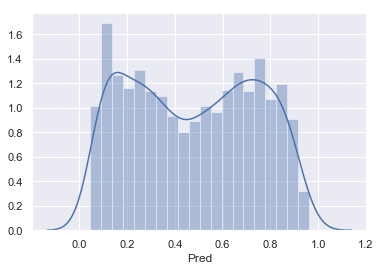

In [8]:
sns.distplot(submission_out['Pred'], bins=20)

In [9]:
submission_out.describe()

,Pred
count,2278.000000
mean,0.476720
std,0.262889
min,0.043853
25%,0.236994
50%,0.482800
75%,0.708437
max,0.963029
